제주 지역(39개)의 기상 데이터를 통해 전력 수요와 SMP 예측 대회  
주어진 데이터는 2018.02.01-2020.01.31 기간동안 39개 지역에서 1시간 단위로 측정된 데이터이다.  
목적은 2020.02.07 ~ 2020.03.05 의 전력수요 및 SMP 예측하는 것  
기온, 강수량, 풍속 등 물리량과 QCFlag가 주어졌다.(total 37개)  
외부 데이터도 사용가능하다.  
주어진 대회 규칙이 있다.  
-> 1~5개의 지역 데이터만 사용가능  
-> 한 지역당 7개의 기상데이터만 사용가능  

train data  
-> 2018.02.01~2020.01.31 기간동안 39개 지역에서 1시간 단위로 측정됨  

test data는 따로 주어지지 않는다.  

target은 smp_max, smp_min, smp_mean, supply로 하루 단위로 제공되었다.  

to do list  
1) 결측치 처리  
2) target과 시간 단위 맞추기  

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [8]:
train = pd.read_csv('data/weather_v1.csv')
print('주어진 data 갯수 = ',len(train),'rows')
train.head()

주어진 data 갯수 =  648852 rows


/home/suna/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (25) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,area,datetime,temp,temp_QCFlag,prec,prec_QCFlag,ws,ws_QCFlag,wd,wd_QCFlag,...,vis,sfctype,weathernumber,sfctemp,sfctemp_QCFlag,landtemp_5cm,landtemp_10cm,landtemp_20cm,landtemp_30cm,station
0,184,2018-02-01 01:00,4.7,0.0,NaN,NaN,3.6,0.0,20.0,0.0,...,1950.0,NaN,NaN,2.9,0.0,3.7,3.9,4.2,4.9,ASOS
1,184,2018-02-01 02:00,4.8,0.0,NaN,NaN,2.6,0.0,360.0,0.0,...,1865.0,NaN,NaN,2.9,0.0,3.6,3.8,4.2,4.9,ASOS
2,184,2018-02-01 03:00,4.8,0.0,NaN,NaN,4.6,0.0,20.0,0.0,...,1855.0,NaN,NaN,3.0,0.0,3.6,3.8,4.3,4.9,ASOS
3,184,2018-02-01 04:00,4.5,0.0,NaN,NaN,5.7,0.0,20.0,0.0,...,1425.0,NaN,NaN,3.0,0.0,3.6,3.8,4.2,5.0,ASOS
4,184,2018-02-01 05:00,4.5,0.0,NaN,9.0,4.4,0.0,20.0,0.0,...,1043.0,NaN,1.0,3.0,0.0,3.5,3.8,4.2,4.9,ASOS


In [6]:
train.isna().sum()/len(train)

area              0.000000
datetime          0.000000
temp              0.005155
temp_QCFlag       0.957243
prec              0.103934
prec_QCFlag       0.973715
ws                0.012846
ws_QCFlag         0.959333
wd                0.014313
wd_QCFlag         0.959226
humid             0.096489
humid_QCFlag      0.957782
vaporP            0.892077
dew               0.892077
landP             0.536304
landP_QCFlag      0.957775
seaP              0.536338
seaP_QCFlag       0.957772
suntime           0.941333
suntime_QCFlag    0.929263
rad               0.970509
snow              0.999419
3hr_snow          0.999955
C                 0.913136
lowmiddleC        0.911538
typeC             0.967671
ceiling           0.940456
vis               0.896651
sfctype           1.000000
weathernumber     0.987321
sfctemp           0.892082
sfctemp_QCFlag    0.957736
landtemp_5cm      0.973002
landtemp_10cm     0.973002
landtemp_20cm     0.973019
landtemp_30cm     0.973002
station           0.000000
d

대부분의 feature가 50%이상의 결측치를 같는다.  
결측치 처리 가이드 라인  
- 10% 미만 : 삭제 or 대치  
- 10~20% : Hot deck or regression or model based imputation  
- 20~50% : regression or model based imputation  
- 50% 이상 : 해당 변수 제거  

전체 data의 결측치를 확인했을땐 대부분의 feature를 사용하지 못하게 된다.  
센서의 고장이나 지역적 특성으로 인해 결측치가 발생할 수 있으므로  
지역별로 나눠서 결측치를 확인해보자  

In [9]:
def area_msv(area_num):
    areaDF = train[train['area']==area_num]
    return areaDF.isna().sum()/len(areaDF)

In [12]:
for i in set(train['area']):
    print(i,'=======================================')
    print(area_msv(i))

779 =======================================
area              0.000000
datetime          0.000000
temp              0.000171
temp_QCFlag       1.000000
prec              0.003083
prec_QCFlag       1.000000
ws                0.000514
ws_QCFlag         1.000000
wd                0.000514
wd_QCFlag         1.000000
humid             0.000171
humid_QCFlag      1.000000
vaporP            1.000000
dew               1.000000
landP             1.000000
landP_QCFlag      1.000000
seaP              1.000000
seaP_QCFlag       1.000000
suntime           1.000000
suntime_QCFlag    1.000000
rad               1.000000
snow              1.000000
3hr_snow          1.000000
C                 1.000000
lowmiddleC        1.000000
typeC             1.000000
ceiling           1.000000
vis               1.000000
sfctype           1.000000
weathernumber     1.000000
sfctemp           1.000000
sfctemp_QCFlag    1.000000
landtemp_5cm      1.000000
landtemp_10cm     1.000000
landtemp_20cm     1.000000
landtemp_30

area              0.000000
datetime          0.000000
temp              0.001199
temp_QCFlag       1.000000
prec              0.003197
prec_QCFlag       1.000000
ws                0.003140
ws_QCFlag         1.000000
wd                0.003140
wd_QCFlag         1.000000
humid             0.000228
humid_QCFlag      1.000000
vaporP            1.000000
dew               1.000000
landP             1.000000
landP_QCFlag      1.000000
seaP              1.000000
seaP_QCFlag       1.000000
suntime           1.000000
suntime_QCFlag    1.000000
rad               1.000000
snow              1.000000
3hr_snow          1.000000
C                 1.000000
lowmiddleC        1.000000
typeC             1.000000
ceiling           1.000000
vis               1.000000
sfctype           1.000000
weathernumber     1.000000
sfctemp           1.000000
sfctemp_QCFlag    1.000000
landtemp_5cm      1.000000
landtemp_10cm     1.000000
landtemp_20cm     1.000000
landtemp_30cm     1.000000
station           0.000000
d

지역별로 결측치 비율을 보았을 때, 대부분 100% 결측치를 가지는 지역과 그렇지 않은 지역으로 나뉜다.  
다른 방식으로 결측치 비율을 한번 더 살펴보자  
target의 시간단위가 하루이므로 기상데이터도 하루 단위로 바꿔 결측치 비율을 살펴보자  
하루 단위로 변환할때 데이터를 평균냈다.  
대부분의 QCFlag는 결측치가 100%이다.  
제외하고 EDA를 계속 진행하도록 하자  

In [25]:
notQC_col = [i for i in train.columns if 'QCFlag' not in i]
train = train[notQC_col]

In [13]:
def area_day_msv(area_num):
    areaDF = train[train['area']==area_num]
    areaDF['date'] = pd.to_datetime(areaDF['datetime'], format='%Y-%m-%d', errors='raise').dt.date
    areaDF = areaDF.groupby(areaDF['date']).mean()
    
    return areaDF.isna().sum()/len(areaDF)

In [26]:
for i in set(train['area']):
    print(i,'=======================================')
    print(area_day_msv(i))

779 =======================================
area             0.0
temp             0.0
prec             0.0
ws               0.0
wd               0.0
humid            0.0
vaporP           1.0
dew              1.0
landP            1.0
seaP             1.0
suntime          1.0
rad              1.0
snow             1.0
3hr_snow         1.0
C                1.0
lowmiddleC       1.0
ceiling          1.0
vis              1.0
sfctype          1.0
weathernumber    1.0
sfctemp          1.0
landtemp_5cm     1.0
landtemp_10cm    1.0
landtemp_20cm    1.0
landtemp_30cm    1.0
dtype: float64
780 =======================================
area             0.000000
temp             0.001385
prec             0.001385
ws               0.000000
wd               0.000000
humid            0.000000
vaporP           1.000000
dew              1.000000
landP            1.000000
seaP             1.000000
suntime          1.000000
rad              1.000000
snow             1.000000
3hr_snow         1.000000
C       

/home/suna/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


area             0.0
temp             0.0
prec             0.0
ws               0.0
wd               0.0
humid            1.0
vaporP           1.0
dew              1.0
landP            1.0
seaP             1.0
suntime          1.0
rad              1.0
snow             1.0
3hr_snow         1.0
C                1.0
lowmiddleC       1.0
ceiling          1.0
vis              1.0
sfctype          1.0
weathernumber    1.0
sfctemp          1.0
landtemp_5cm     1.0
landtemp_10cm    1.0
landtemp_20cm    1.0
landtemp_30cm    1.0
dtype: float64
724 =======================================
area             0.000000
temp             0.000000
prec             0.000000
ws               0.000000
wd               0.000000
humid            0.000000
vaporP           1.000000
dew              1.000000
landP            0.927298
seaP             0.927298
suntime          1.000000
rad              1.000000
snow             1.000000
3hr_snow         1.000000
C                1.000000
lowmiddleC       1.000000


area             0.000000
temp             0.000000
prec             0.000000
ws               0.000000
wd               0.000000
humid            0.013274
vaporP           1.000000
dew              1.000000
landP            0.000000
seaP             0.000000
suntime          1.000000
rad              1.000000
snow             1.000000
3hr_snow         1.000000
C                1.000000
lowmiddleC       1.000000
ceiling          1.000000
vis              1.000000
sfctype          1.000000
weathernumber    1.000000
sfctemp          1.000000
landtemp_5cm     1.000000
landtemp_10cm    1.000000
landtemp_20cm    1.000000
landtemp_30cm    1.000000
dtype: float64
893 =======================================
area             0.0
temp             0.0
prec             0.0
ws               0.0
wd               0.0
humid            0.0
vaporP           1.0
dew              1.0
landP            0.0
seaP             0.0
suntime          1.0
rad              1.0
snow             1.0
3hr_snow         1

지역별 feature별 결측치 비율을 보기 쉽게 bar plot으로 그려보았다.  

In [129]:
def MSV_bar(area_num):
    plt.figure(figsize=(20, 3))
    plt.bar(np.arange(25), list(area_day_msv(area_num)))
    plt.show()

In [126]:
area = pd.read_csv('data/lookupTable_area.csv')

184 제주


/home/suna/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


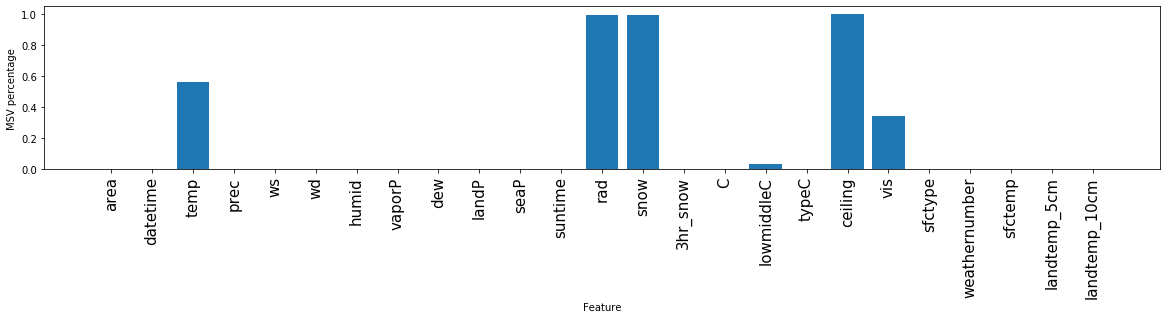

185 고산


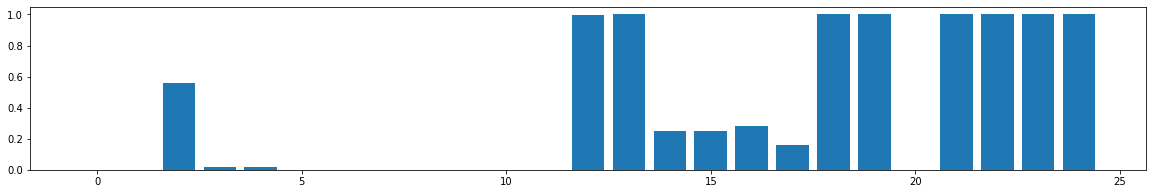

188 성산


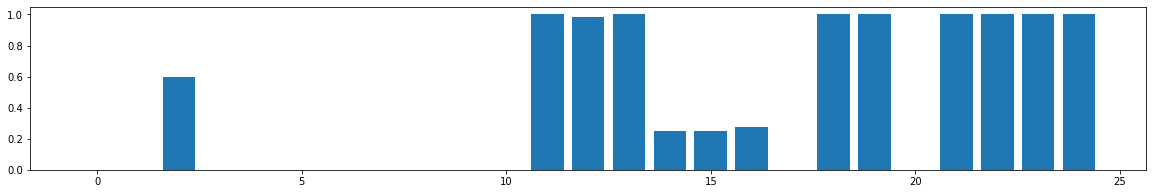

189 서귀포


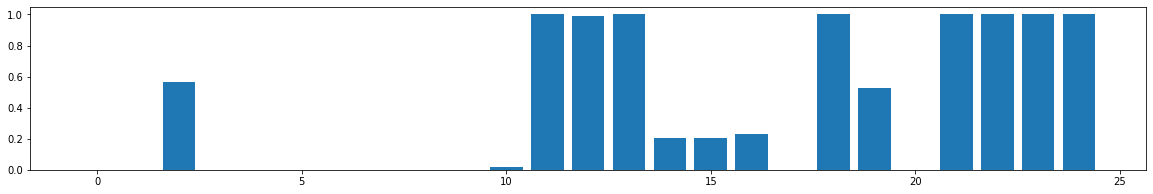

328 중문


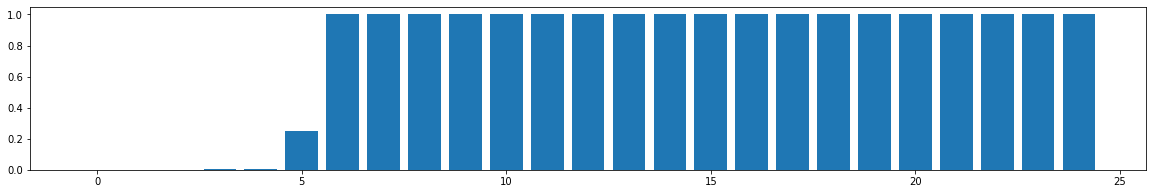

329 산천단


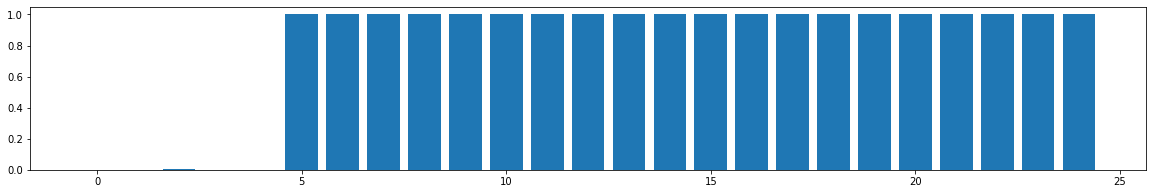

330 대흘


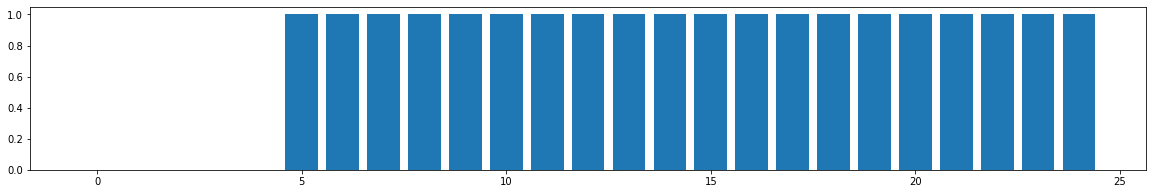

724 추자도


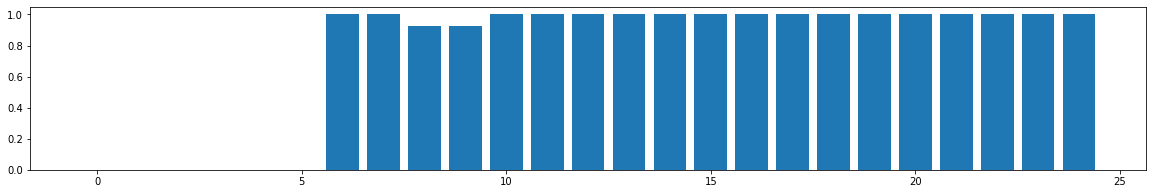

725 우도


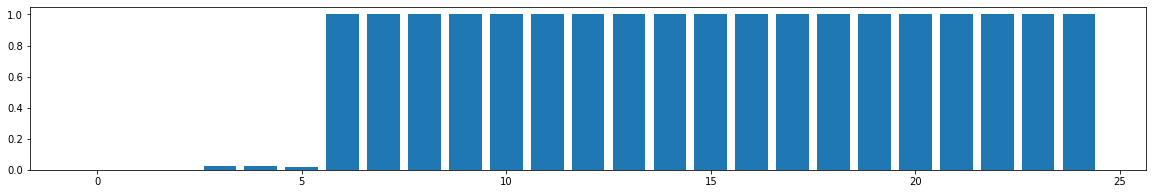

726 마라도


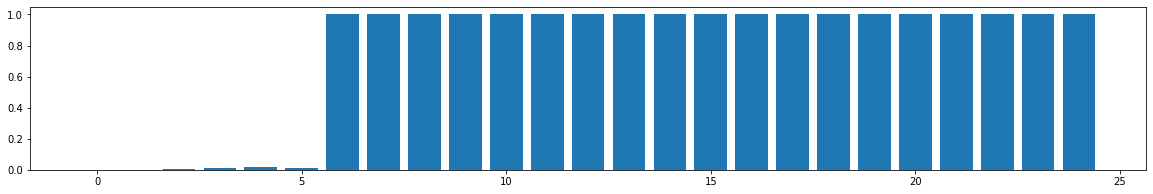

727 유수암


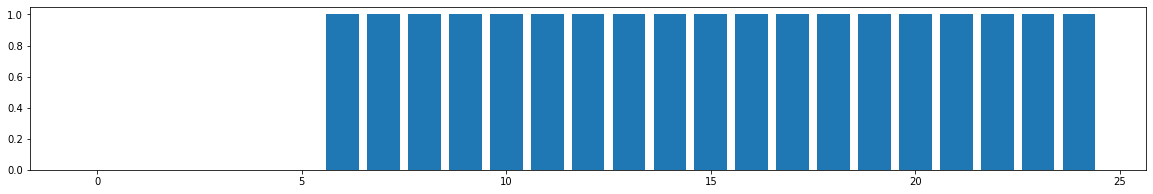

751 선흘


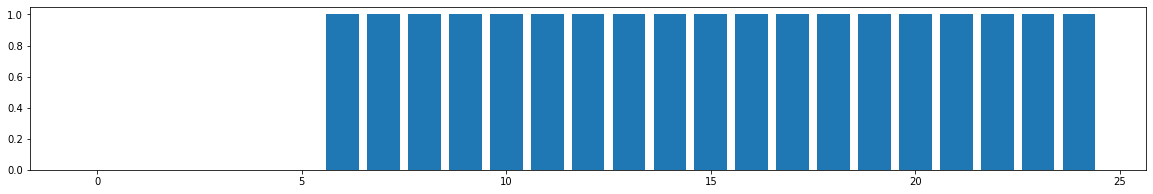

752 서광


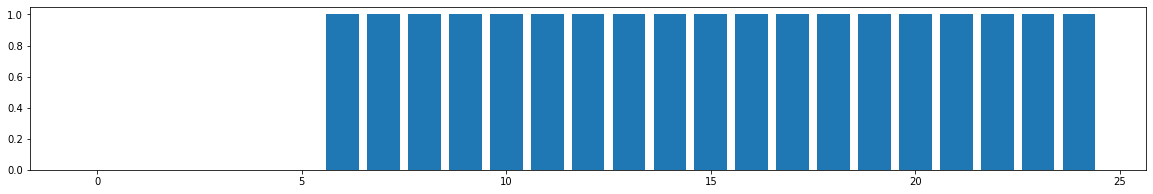

753 어리목


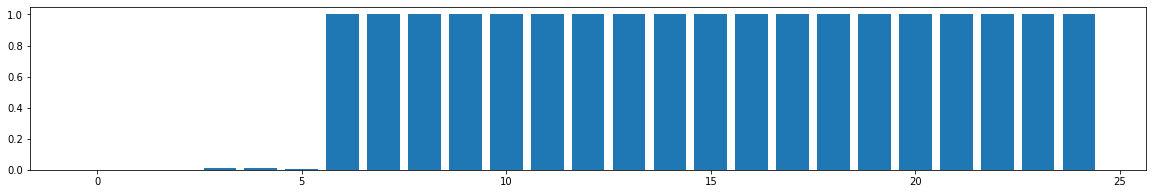

779 한림


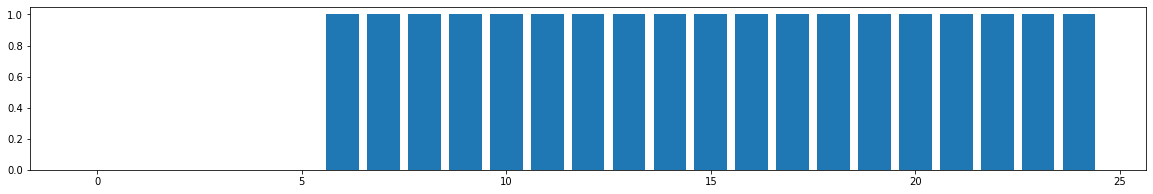

780 제주남원


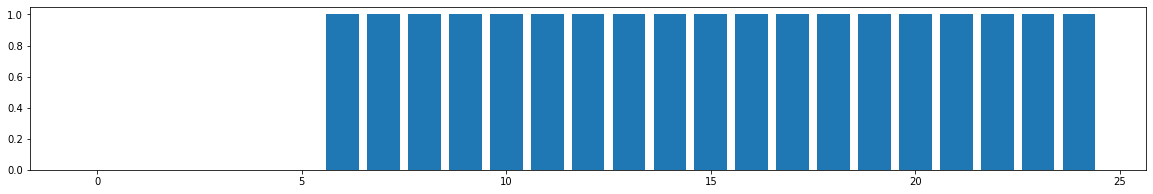

781 구좌


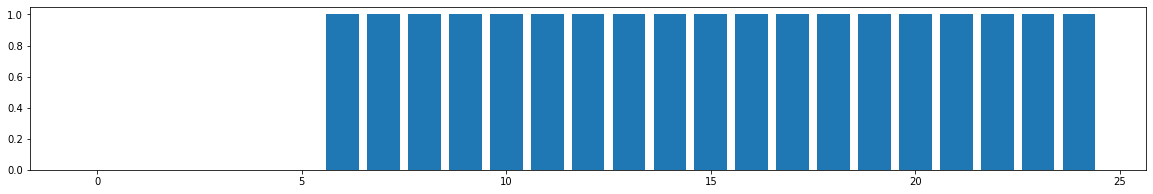

782 성판악


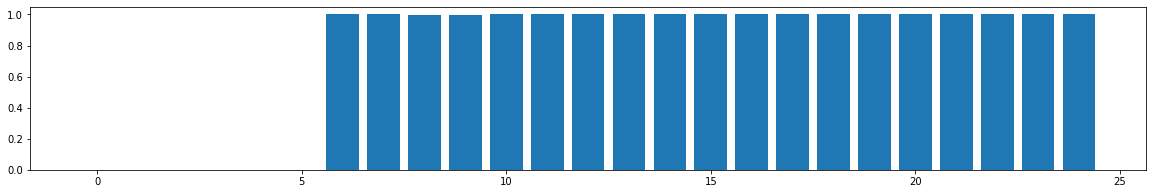

792 표선


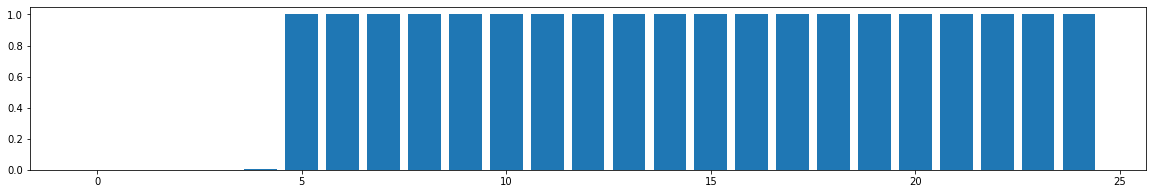

793 대정


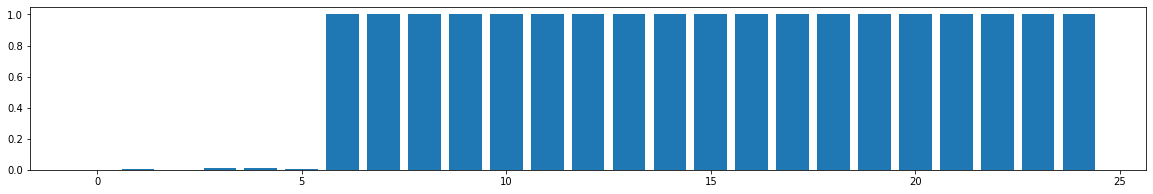

855 가파도


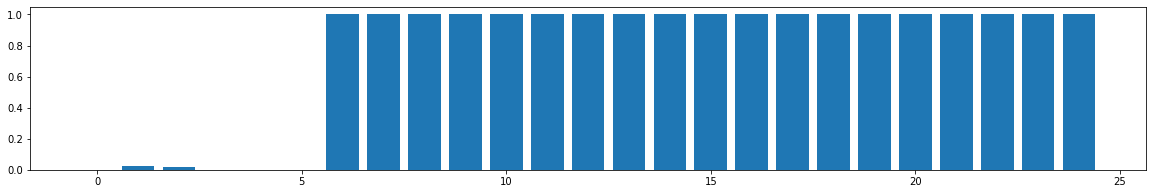

861 월정


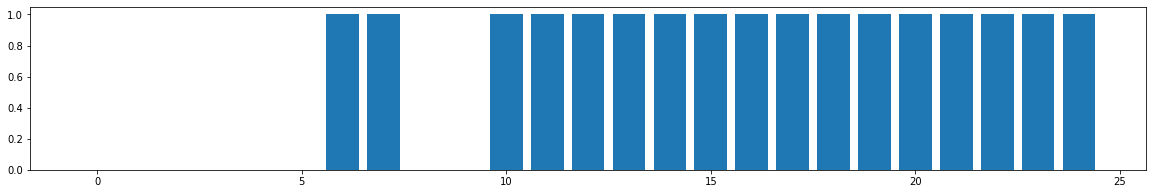

862 송당


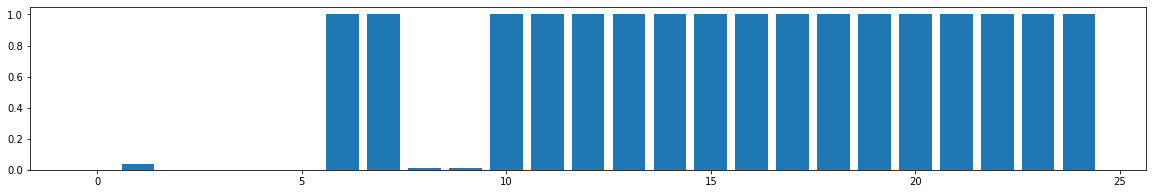

863 외도


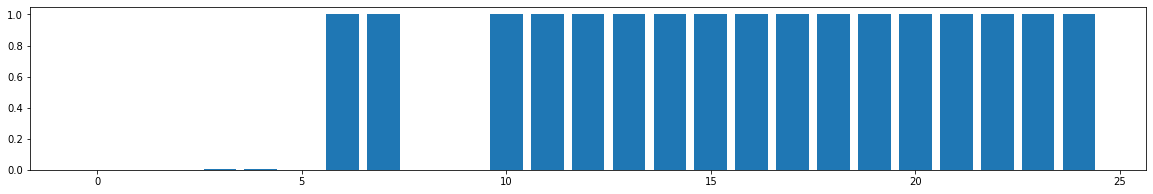

865 오등


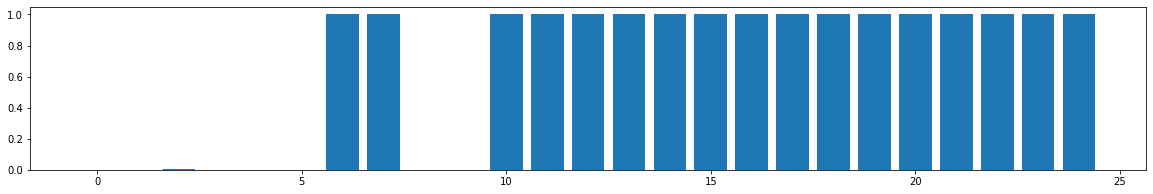

866 한라생태숲


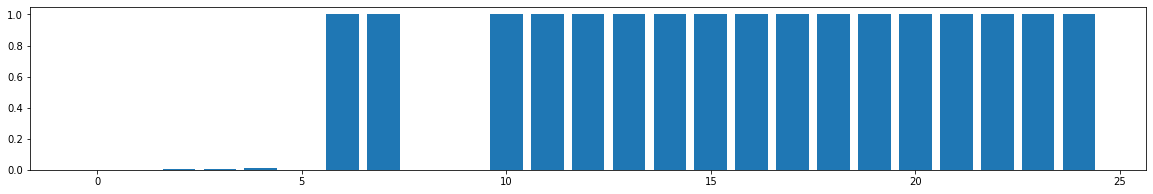

867 삼각봉


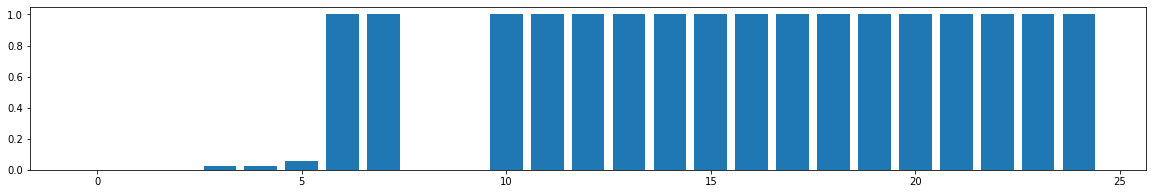

868 사제비


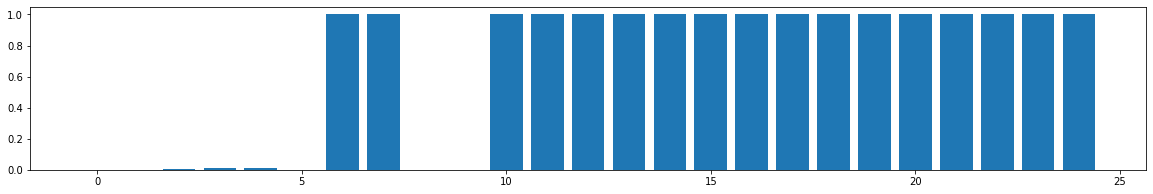

869 영실


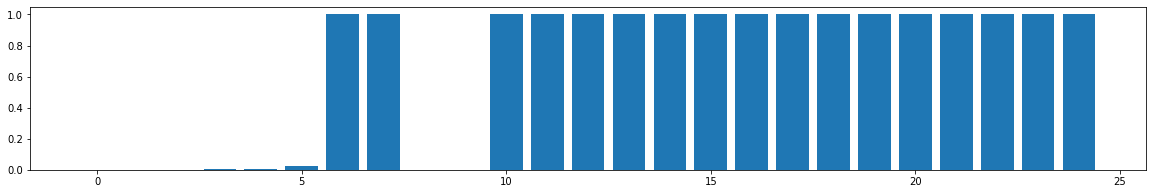

870 진달래밭


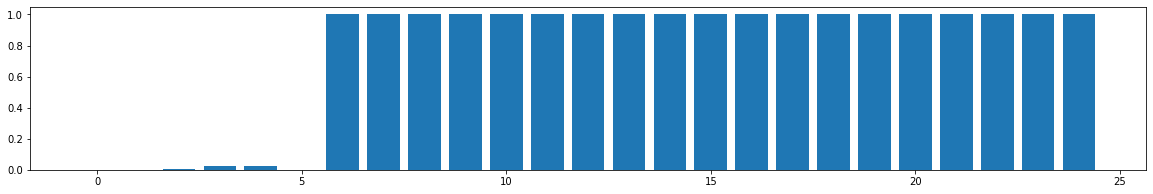

871 윗세오름


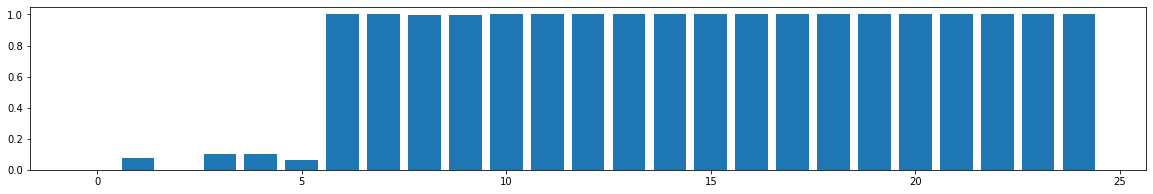

880 금악


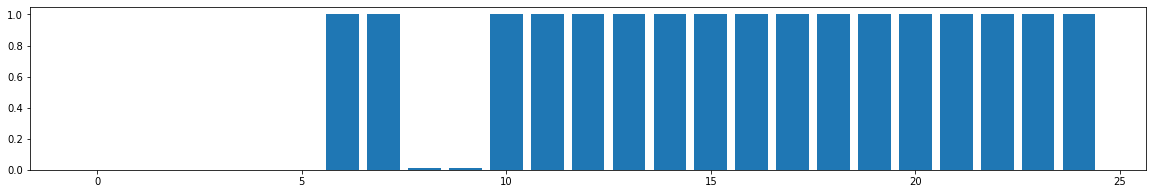

883 새별오름


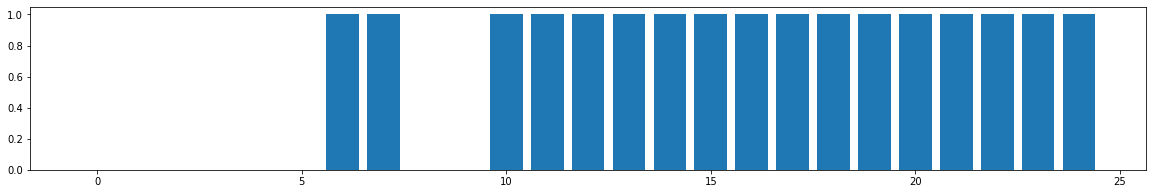

884 기상(과)


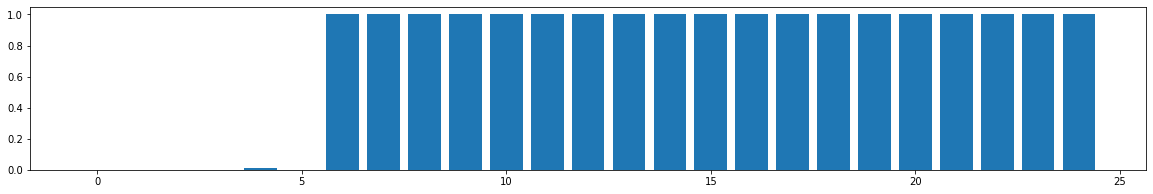

885 태풍센터


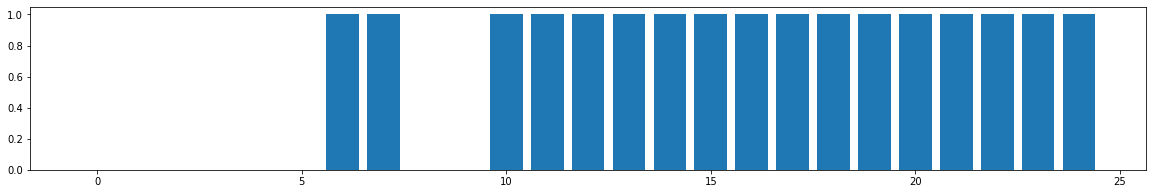

890 신례


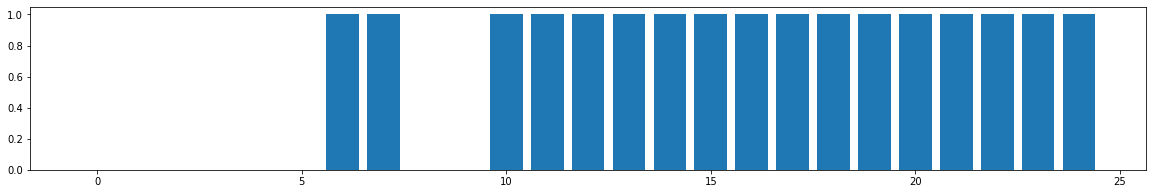

891 색달


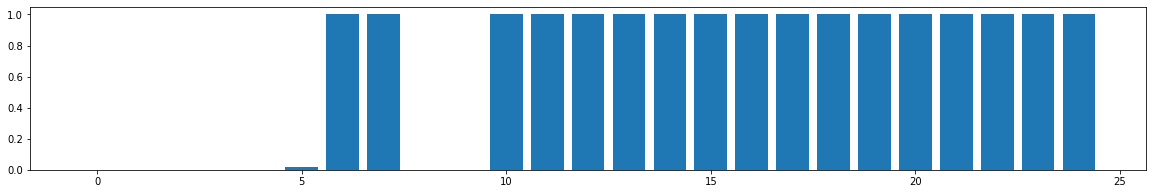

892 성산수산


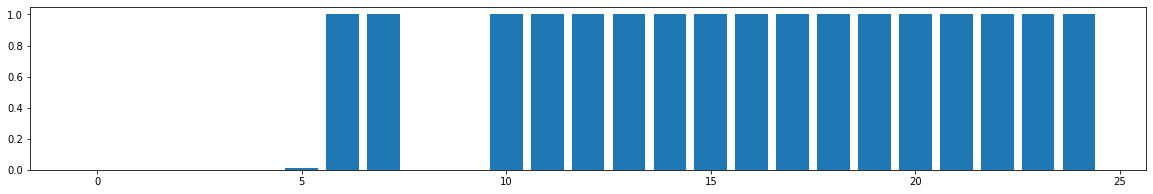

893 애월


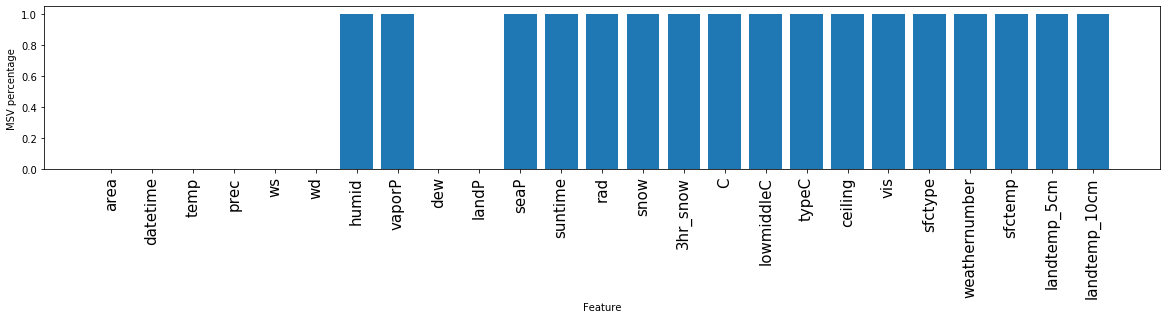

In [137]:
for i in range(39):
    print(area['area'].iloc[i], area['name'].iloc[i])
    if i==0 or i==38:
        plt.figure(figsize=(20, 3))
        plt.bar(np.arange(25), list(area_day_msv(area['area'].iloc[i])))
        plt.xlabel('Feature')
        plt.ylabel('MSV percentage')
        plt.xticks(np.arange(25),notQC_col,fontsize=15, rotation=90)
        plt.show()
    else:
        MSV_bar(area['area'].iloc[i])